In [18]:
# Imports 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import joblib
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

file_path = '../data/raw/KDDTrain+.csv'

# Load the CSV file
data = pd.read_csv(file_path)

# Convert to a pandas DataFrame
df = pd.DataFrame(data)
df.columns = df.columns.str.strip("'")

#print(df.head())

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = df.select_dtypes(include=['float64', 'int64'])
df[numerical_features.columns] = scaler.fit_transform(numerical_features)

#for col in df.columns:
#    print(col)


In [3]:
df = pd.get_dummies(df)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming 'class_normal' and 'class_anomaly' are binary columns indicating the class
normal_data = df[df["class_normal"] == 1]
anomalies = df[df['class_anomaly'] == 1]

# Split the normal data
X_train, X_temp = train_test_split(normal_data, test_size=0.2, random_state=42)
X_val, X_test_normal = train_test_split(X_temp, test_size=0.5, random_state=42)

# Remove 'class_normal' and 'class_anomaly' columns
X_train = X_train.drop(['class_normal', 'class_anomaly'], axis=1)
X_val = X_val.drop(['class_normal', 'class_anomaly'], axis=1)
X_test_normal = X_test_normal.drop(['class_normal', 'class_anomaly'], axis=1)

# Fit and transform scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and normal test data
X_val_scaled = scaler.transform(X_val)
X_test_normal_scaled = scaler.transform(X_test_normal)

# Prepare anomaly test data
X_test_anomaly = anomalies.sample(n=len(X_test_normal))
X_test_anomaly_scaled = scaler.transform(X_test_anomaly.drop(['class_normal', 'class_anomaly'], axis=1))

# Combine scaled normal and anomaly samples to create the final test set
X_test_scaled = np.concatenate([X_test_normal_scaled, X_test_anomaly_scaled])

# Prepare true labels for the test set
y_true_normal = np.zeros(len(X_test_normal))
y_true_anomaly = np.ones(len(X_test_anomaly))
y_true = np.concatenate([y_true_normal, y_true_anomaly])


In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam

X_train = np.asarray(X_train).astype(np.float32)
X_val = np.asarray(X_val).astype(np.float32)
X_train_scaled = np.asarray(X_train_scaled).astype(np.float32)
X_val_scaled = np.asarray(X_val_scaled).astype(np.float32)
X_test_scaled = np.asarray(X_test_scaled).astype(np.float32)


input_dim = X_train_scaled.shape[1]
encoding_dim = 16  # or choose a different size for the encoding layer

# Encoder
input_layer = Input(shape=(input_dim,))
# encoder = Dense(1024, activation="relu", activity_regularizer=l2(1e-3))(input_layer)
# encoder = Dropout(0.5)(encoder)
# encoder = Dense(512, activation="relu", activity_regularizer=l2(1e-3))(encoder)
# encoder = Dense(256, activation="relu", activity_regularizer=l2(1e-3))(encoder)
encoder = Dense(128, activation="relu", activity_regularizer=l2(1e-3))(input_layer)
encoder = Dropout(0.5)(encoder)
encoder = Dense(64, activation="relu", activity_regularizer=l2(1e-3))(encoder)  # Bottleneck layer

#, activity_regularizer=l1(1e-5)

# Decoder
decoder = Dense(128, activation="relu", activity_regularizer=l2(1e-3))(encoder)
# decoder = Dense(256, activation="relu", activity_regularizer=l2(1e-3))(decoder)
# decoder = Dense(512, activation="relu", activity_regularizer=l2(1e-3))(decoder)
# decoder = Dense(1024, activation="relu", activity_regularizer=l2(1e-3))(decoder)
decoder = Dropout(0.5)(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)


autoencoder = Model(inputs=input_layer, outputs=decoder)

# Specify a learning rate
learning_rate = 0.0001

# Create and compile the model with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)


autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

history = autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_val_scaled, X_val_scaled))


Epoch 1/20
421/421 [==============================] - 3s 4ms/step - loss: 0.8432 - val_loss: 1.3136
Epoch 2/20
421/421 [==============================] - 1s 3ms/step - loss: 0.6963 - val_loss: 1.2523
Epoch 3/20
421/421 [==============================] - 1s 4ms/step - loss: 0.6549 - val_loss: 1.2217
Epoch 4/20
421/421 [==============================] - 2s 4ms/step - loss: 0.6319 - val_loss: 1.2027
Epoch 5/20
421/421 [==============================] - 2s 4ms/step - loss: 0.6165 - val_loss: 1.1869
Epoch 6/20
421/421 [==============================] - 1s 3ms/step - loss: 0.6041 - val_loss: 1.1735
Epoch 7/20
421/421 [==============================] - 2s 4ms/step - loss: 0.5936 - val_loss: 1.1631
Epoch 8/20
421/421 [==============================] - 2s 4ms/step - loss: 0.5853 - val_loss: 1.1538
Epoch 9/20
421/421 [==============================] - 2s 4ms/step - loss: 0.5779 - val_loss: 1.1459
Epoch 10/20
421/421 [==============================] - 2s 4ms/step - loss: 0.5715 - val_loss: 1.1386

In [24]:

# Predict using the autoencoder
X_test_pred = autoencoder.predict(X_test_scaled)
reconstruction_error = np.mean(np.power(X_test_scaled - X_test_pred, 2), axis=1)

# Define a threshold and predict anomalies
threshold = 0.25
y_pred = [1 if e > threshold else 0 for e in reconstruction_error]


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Optionally, print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


421/421 [==============================] - 2s 6ms/step
Accuracy: 0.8725315515961396
Precision: 0.8070239843367597
Recall: 0.9792130660727543
F1 Score: 0.8848192124505266
Confusion Matrix:
[[5158 1577]
 [ 140 6595]]


<Figure size 1200x800 with 0 Axes>

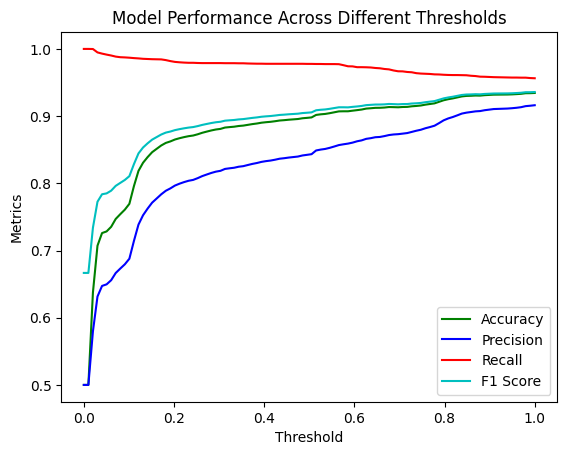

In [27]:
# Define a range of thresholds
thresholds = np.linspace(0, 1, 100)

# Initialize lists to store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
false_negatives = []
false_positives = []

for threshold in thresholds:
    y_pred = [1 if e > threshold else 0 for e in reconstruction_error]
    
    accuracies.append(accuracy_score(y_true, y_pred))
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    f1_scores.append(f1_score(y_true, y_pred))
    
    # Calculate confusion matrix and extract false negatives (FN)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    false_negatives.append(fn)
    false_positives.append(fp)

plt.figure(figsize=(12, 8))

# Create a plot with a primary and secondary y-axis
fig, ax1 = plt.subplots()
#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plotting the metrics on the primary y-axis
accuracy_line, = ax1.plot(thresholds, accuracies, label='Accuracy', color='g')
precision_line, = ax1.plot(thresholds, precisions, label='Precision', color='b')
recall_line, = ax1.plot(thresholds, recalls, label='Recall', color='r')
f1_score_line, = ax1.plot(thresholds, f1_scores, label='F1 Score', color='c')

# Plot False Negatives on the secondary y-axis
#false_negatives_line, = ax2.plot(thresholds, false_negatives, label='False Negatives', color='y')
#false_positives_line, = ax2.plot(thresholds, false_positives, label='False Positives', color='m')

# Labels and titles
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Metrics')
#ax2.set_ylabel('False Negatives', color='y')
#ax2.set_ylabel('False Positives', color='m')

# Collecting handles and labels for both axes
handles = [accuracy_line, precision_line, recall_line, f1_score_line]
labels = [h.get_label() for h in handles]

# Creating a single legend for both lines
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.11))

plt.title('Model Performance Across Different Thresholds')
plt.show()


AUC: 0.9700927409420919


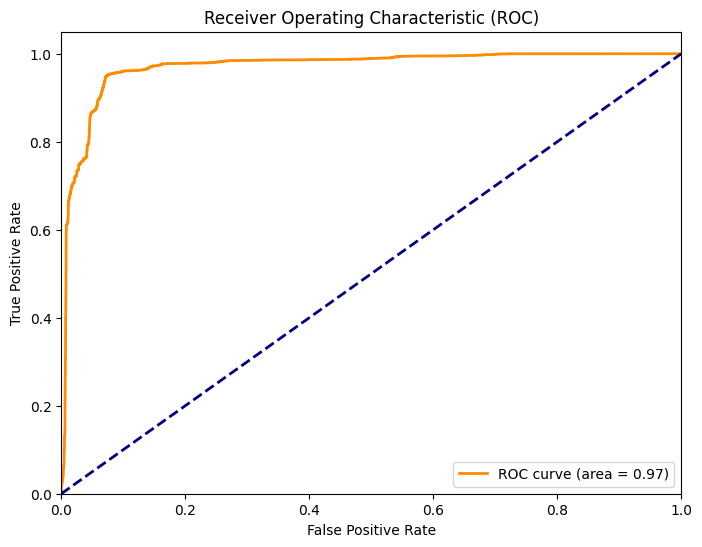

In [28]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming y_true contains the actual labels for the test set (0 for normal, 1 for anomalies)
# and reconstruction_error contains the reconstruction error from the autoencoder

# The threshold does not directly apply here; instead, use reconstruction error directly
fpr, tpr, thresholds = roc_curve(y_true, reconstruction_error)
roc_auc = auc(fpr, tpr) 

print(f"AUC: {roc_auc}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


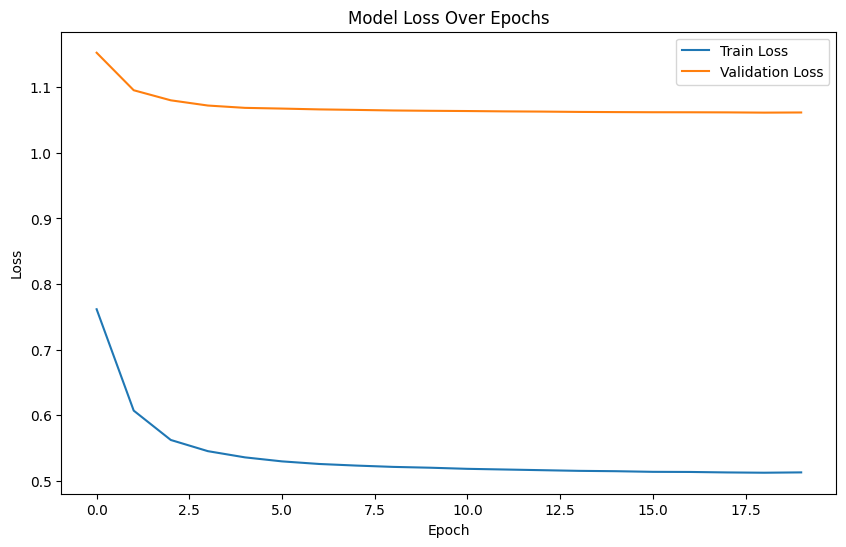

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
